# Data Cleaning

In [ ]:
%%time
%pwd
from pyspark import SparkContext
sc = SparkContext(pyFiles=['/mnt/workspace/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section2-PCA/PCA/data_preparation/lib/numpy_pack.py'])

In [7]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, BinaryType, FloatType

sqlContext = SQLContext(sc)

In [2]:
#sc.stop()


In [2]:
!du -s /mnt/workspace/Data/*

716	/mnt/workspace/Data/US_stations.tsv
2248960	/mnt/workspace/Data/weather.parquet


In [13]:
import pandas as pd
stations_pdf=pd.read_csv('/mnt/workspace/Data/US_stations.tsv',sep='\t')
stations_pdf.head()

,station,dist_coast,latitude,longitude,elevation,state,name
0,USC00044534,107.65500,36.0042,-119.9600,73.2,CA,KETTLEMAN CITY
1,USC00356784,0.61097,42.7519,-124.5011,12.8,OR,PORT ORFORD NO 2
2,USC00243581,1316.54000,47.1064,-104.7183,632.8,MT,GLENDIVE
3,USC00205601,685.50100,41.7500,-84.2167,247.2,MI,MORENCI
4,CA005010480,908.27100,49.9170,-99.9500,409.0,NaN,BRANDON AIRPORT


In [21]:
schema = StructType([StructField("Station",     StringType(), True),
                     StructField("dist_coast",  FloatType(), True),
                     StructField("latitude",    FloatType(),True),
                     StructField("longitude",    FloatType(),True),
                     StructField("elevation",    FloatType(),True),
                     StructField("state",     StringType(), True),
                     StructField("name",     StringType(), True),
                    ])
schema

StructType(List(StructField(Station,StringType,true),StructField(dist_coast,FloatType,true),StructField(latitude,FloatType,true),StructField(longitude,FloatType,true),StructField(elevation,FloatType,true),StructField(state,StringType,true),StructField(name,StringType,true)))

In [35]:
stations = sqlContext.createDataFrame(stations_pdf,schema)
stations.show(4)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|dist_coast|latitude|longitude|elevation|state|            name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00044534|   107.655| 36.0042|  -119.96|     73.2|   CA|  KETTLEMAN CITY|
|USC00356784|   0.61097| 42.7519|-124.5011|     12.8|   OR|PORT ORFORD NO 2|
|USC00243581|   1316.54| 47.1064|-104.7183|    632.8|   MT|        GLENDIVE|
|USC00205601|   685.501|   41.75| -84.2167|    247.2|   MI|         MORENCI|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 4 rows



In [34]:
%%time
Query="""
SELECT *
FROM parquet.`/weather/weather.parquet` 
WHERE (Measurement='PRCP'
	 or Measurement='TMIN'
	 or Measurement='TMAX'
	 or Measurement='SNOW'
	 or Measurement='SNWD'
	 or Measurement='TOBS')
"""
Weather = sqlContext.sql(Query)
Weather.show(4)

+-----------+-----------+----+--------------------+
|    Station|Measurement|Year|              Values|
+-----------+-----------+----+--------------------+
|IN011020501|       PRCP|1939|[00 00 00 00 00 0...|
|IN011020501|       PRCP|1940|[00 00 00 00 00 0...|
|IN011020501|       PRCP|1941|[00 00 00 00 00 0...|
|IN011020501|       PRCP|1942|[00 00 00 00 00 0...|
+-----------+-----------+----+--------------------+
only showing top 4 rows

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.8 s


In [42]:
%%time
US_Weather=stations.select('Station').join(Weather,on='Station', how='inner')
US_Weather.show(5)

+-----------+-----------+----+--------------------+
|    Station|Measurement|Year|              Values|
+-----------+-----------+----+--------------------+
|CA001013051|       PRCP|1974|[00 7E 00 7E 00 7...|
|CA001013051|       PRCP|1975|[00 00 00 54 28 5...|
|CA001013051|       PRCP|1976|[00 00 C0 50 98 5...|
|CA001013051|       PRCP|1977|[00 7E 00 7E 00 0...|
|CA001013051|       PRCP|1978|[00 00 20 54 30 5...|
+-----------+-----------+----+--------------------+
only showing top 5 rows

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 22.4 s


In [46]:
%%time
Weather.groupBy('Measurement').count().show()

+-----------+-------+
|Measurement|  count|
+-----------+-------+
|       TMIN| 969579|
|       TOBS| 478981|
|       TMAX| 967931|
|       SNOW| 881399|
|       SNWD| 864192|
|       PRCP|2521007|
+-----------+-------+

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.55 s


In [43]:
US_Weather.count()

3259494

In [48]:
%%time
count_by_year=Weather.groupBy('Year').count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.36 ms


In [49]:
count_by_year_pdf=count_by_year.toPandas()

In [61]:
count_by_year_pdf=count_by_year_pdf.sort_values('Year')

In [59]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


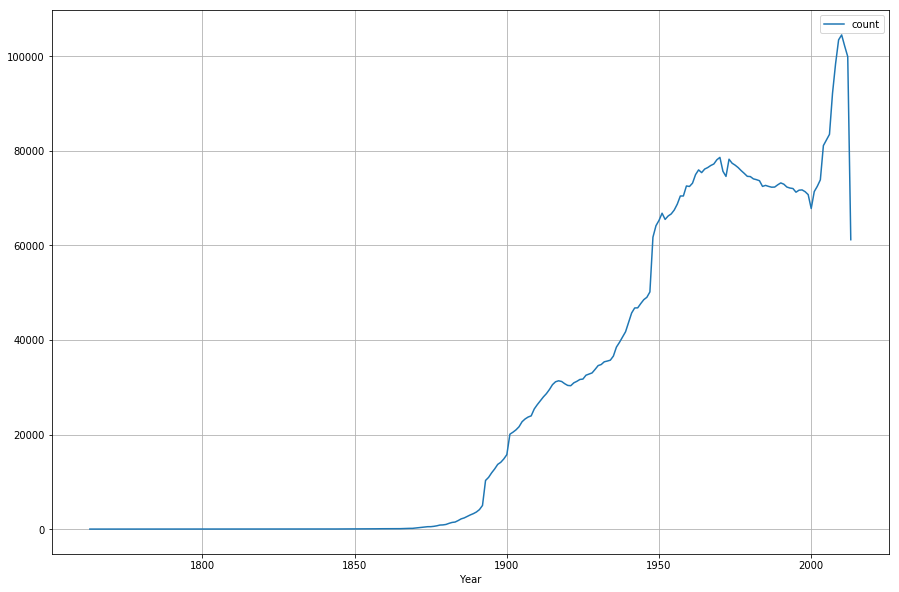

In [70]:
count_by_year_pdf.plot('Year','count',figsize=(15,10));
grid()

In [71]:
%%time 
outfilename="hdfs:///weather/US_weather.parquet"
US_Weather.write.save(outfilename)

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 46.2 s


In [72]:
%%time 
outfilename="hdfs:///weather/US_stations.parquet"
stations.write.save(outfilename)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 10.7 s


In [73]:
!hdfs dfs -ls /weather/

Found 3 items
drwxr-xr-x   - hadoop hadoop          0 2018-03-15 22:22 /weather/US_stations.parquet
drwxr-xr-x   - hadoop hadoop          0 2018-03-15 22:20 /weather/US_weather.parquet
drwxr-xr-x   - hadoop hadoop          0 2018-03-15 20:27 /weather/weather.parquet


In [80]:
data_dir='/mnt/workspace/Data'
!ls $data_dir

US_stations.tsv  weather.parquet


In [85]:
def copy_to_s3(data_dir,filename):
    #supposedly s3-dist-cp is better and faster than this two step method
    # https://aws.amazon.com/blogs/big-data/seven-tips-for-using-s3distcp-on-amazon-emr-to-move-data-efficiently-between-hdfs-and-amazon-s3/
    #copy to headnode/data_dir
    !hadoop fs -copyToLocal /weather/$filename $data_dir/$filename
    # Copy parquet directory from headnode to s3
    !aws s3 cp --recursive --quiet $data_dir/$filename s3://dse-weather/$filename

In [87]:
%%time
for filename in ['US_weather.parquet','US_stations.parquet']:
    copy_to_s3(data_dir,filename)

copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/_SUCCESS': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00000-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00001-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00002-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00003-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00004-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00005-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.par

copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00084-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00085-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00086-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00087-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00088-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00089-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part

copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00148-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00149-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00150-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00151-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00152-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part-00153-497f06cd-3801-4256-a555-79f05b7400d6-c000.snappy.parquet': File exists
copyToLocal: `/mnt/workspace/Data/US_weather.parquet/US_weather.parquet/part